In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as tt
import numpy as np
import time

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cpu


In [2]:
#Network  parameters 
input_size = 28*28
num_hidden_layders = 1
hidden_size = 500
output_size = 27
epoch_size = 2
batch_size = 200
learning_rate = 1

In [3]:
#Dataset
train_dataset = torchvision.datasets.EMNIST(root="./data",train = True,split = "letters",download = True,
                                            transform = tt.Compose([lambda img:tt.functional.rotate(img,-90),
                                                                    lambda img:tt.functional.hflip(img),
                                                                    tt.ToTensor()]))

test_dataset = torchvision.datasets.EMNIST(root="./data",train = False,split = "letters",download = False,
                                            transform = tt.Compose([lambda img:tt.functional.rotate(img,-90),
                                                                    lambda img:tt.functional.hflip(img),
                                                                    tt.ToTensor()]))


In [4]:
#Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle = True)


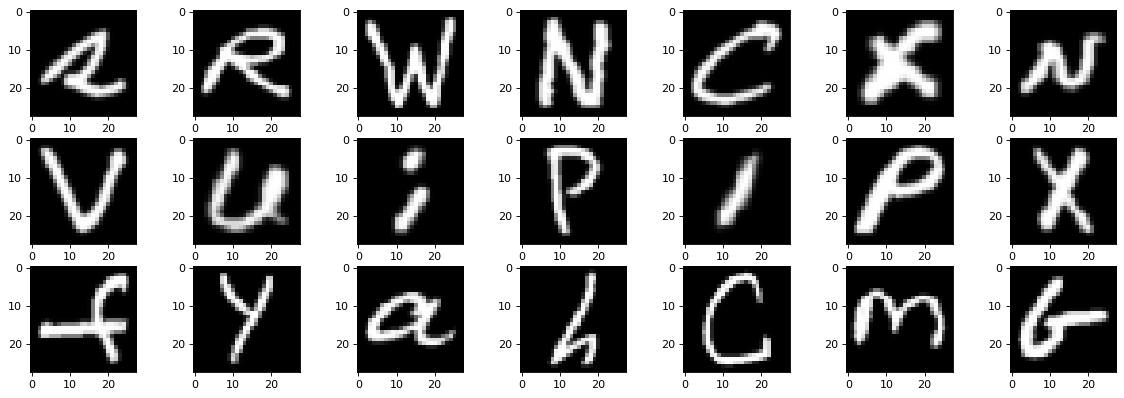

In [5]:
# looking at the data
sample_train_loader = iter(train_loader)
img_from_test,label_example = sample_train_loader.next()


plt.figure(figsize=(18, 6), dpi=80)

for i in range(21):
  plt.subplot(3,7,i+1)
  plt.imshow(img_from_test[i][0],cmap = "gray")

plt.show()

In [6]:
#Model
class imgrec(nn.Module):
  def __init__(self,input_size,hidden_size,class_size):
    super(imgrec,self).__init__()
    self.input_size = input_size
    self.lin1 = nn.Linear(input_size, hidden_size)#inputlayer
    self.leakyReLu = nn.LeakyReLU()#activation function
    self.lin2 = nn.Linear(hidden_size,class_size)#hiddenlayer

  def forward(self,x):
      out = self.lin1(x)
      out = self.leakyReLu(out)#activation function
      out = self.lin2(out)
      #not using softmax since i am going to use cross entropy
      return out



model = imgrec(input_size, hidden_size, output_size).to(device)

In [7]:
# loss
loss_func = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [45]:
#training 
n_steps = len(train_loader)

start = time.time()
for epoch in range(epoch_size):
  for i, (images,labels) in enumerate(train_loader):
    images = images.reshape(batch_size,28*28).to(device)
    labels = labels.to(device)


    #forward 
    outputs = model(images)
    loss = loss_func(outputs,labels)

    #backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 156 == 0:
      print(f"epoch {epoch+1} / {epoch_size}, step {i+1}/{n_steps},loss = {loss.item():.3f} ")
      
print("Done!")
end = time.time()

epoch 1 / 2, step 156/624,loss = 0.252 
epoch 1 / 2, step 312/624,loss = 0.300 
epoch 1 / 2, step 468/624,loss = 0.214 
epoch 1 / 2, step 624/624,loss = 0.340 
epoch 2 / 2, step 156/624,loss = 0.186 
epoch 2 / 2, step 312/624,loss = 0.370 
epoch 2 / 2, step 468/624,loss = 0.162 
epoch 2 / 2, step 624/624,loss = 0.245 
Done!


In [46]:
#testing
with torch.no_grad():
  n_correct = 0
  n_samples = 0

  for images,labels in test_loader:
    images = images.reshape(batch_size,28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)

    _,pred = torch.max(outputs,1)
    n_samples +=labels.shape[0]
    n_correct += (pred == labels).sum().item()

  acc = n_correct/n_samples * 100 

  print(f"Acc = {acc:.3f}%")
  print(f"Time = {round(end - start,3)} sek")


Acc = 90.611%
Time = 50.348 sek


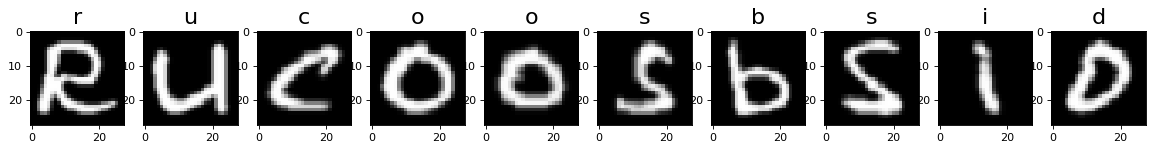

In [21]:
with torch.no_grad():
  iter_test_loader = iter(test_loader)
  img,label = iter_test_loader.next()

  reshaped_img = img.reshape(batch_size,28*28).to(device)

  outputs = model(reshaped_img)
  _,pred = torch.max(outputs,1)


plt.figure(figsize=(18, 6), dpi=80)
for i in range(10):
  plt.subplot(1,10,i+1)   
  plt.imshow(img[i][0],cmap = "gray")
  plt.title(f"{chr(pred[i]+96)}", fontsize=20)

plt.show()

In [20]:
def savefunction(state):
  if state == "on":
    f = open("training_second_round.txt", "a")
    f.write(str(learning_rate)+ ' ' + str(round(acc,3))  + '\n')
    f.close()
  else:
    print("Save turned off")

savefunction("off")

Save turned off


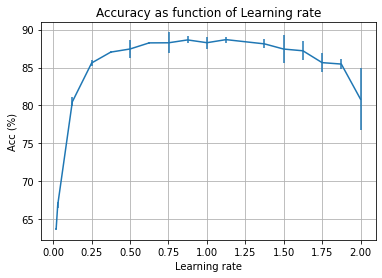

In [12]:
acc_round_1 = np.genfromtxt("training.txt", delimiter=",")
acc_round_2 = np.genfromtxt("training_second_round.txt", delimiter=",")
diff  = acc_round_1[:,1]-acc_round_2[:,1]
mean = (acc_round_1[:,1]+acc_round_2[:,1])/2


plt.errorbar(acc_round_1[:,0], mean, yerr=diff)
plt.title("Accuracy as function of Learning rate")
plt.xlabel("Learning rate")
plt.ylabel("Acc (%)")
plt.grid()
plt.show()

In [40]:
print(f"Highest accuracy of {mean[10]}% ± {round(diff[10],3)}% occurres with learning rate = {acc_round_1[10,0]} ")

Highest accuracy of 88.673% ± 0.384% occurres with learning rate = 1.125 
